# Pokemon EDA
Using SQL & Python to conduct Exploratory Data Analysis (EDA) on Pokemon data ([Kaggle](https://www.kaggle.com/abcsds/pokemon)).

**GitHub: [henrylin03](https://github.com/henrylin03/)**

![Pokemons](https://external-preview.redd.it/NXrR_qnMRHrwUoE8pbeiX26fq4mNctFsmdEghRVApSQ.jpg?auto=webp&s=b18e1b0df84f417036d4e1ac0affb6245a071ebf)

## Setup
### Importing packages

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

### Reading in CSV & creating SQL database

In [2]:
df = pd.read_csv('input/Pokemon.csv')
# df.head()

In [3]:
engine = create_engine('sqlite://', echo=False)

df.to_sql('pokemon', engine, if_exists='replace', index=False)

## Inspecting & Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Cleaning column names by:
1. Removing spaces and dots, and
2. Describing "#" as the "National Pokedex number"

In [5]:
df.columns = df.columns\
                .str.replace(' ', '')\
                .str.replace('.', '')\
                .str.replace('#', 'NdexID')

print(df.columns)

# replace SQL database:
df.to_sql('pokemon', engine, if_exists='replace', index=False)

Index(['NdexID', 'Name', 'Type1', 'Type2', 'Total', 'HP', 'Attack', 'Defense',
       'SpAtk', 'SpDef', 'Speed', 'Generation', 'Legendary'],
      dtype='object')


<ipython-input-5-20c32ad60880>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns\


Number of rows:

In [6]:
pd.read_sql_query("""SELECT COUNT(*) row_count 
                     FROM pokemon""", engine)

,row_count
0,800


First 5 rows:

In [7]:
pd.read_sql_query("""SELECT * 
                     FROM pokemon 
                     LIMIT 5""", engine)

,NdexID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,0


### Missing

In [8]:
df.isna().sum()

NdexID          0
Name            0
Type1           0
Type2         386
Total           0
HP              0
Attack          0
Defense         0
SpAtk           0
SpDef           0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [9]:
df[df.isnull().any(axis=1)].sort_values('Name')

,NdexID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
68,63,Abra,Psychic,NaN,310,25,20,15,105,55,90,1,False
392,359,Absol,Dark,NaN,465,65,130,60,75,60,75,3,False
393,359,AbsolMega Absol,Dark,NaN,565,65,150,60,115,60,115,3,False
678,617,Accelgor,Bug,NaN,495,80,70,40,100,60,145,5,False
333,306,AggronMega Aggron,Steel,NaN,630,70,140,230,60,80,50,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,335,Zangoose,Normal,NaN,458,73,115,60,60,60,90,3,False
582,523,Zebstrika,Electric,NaN,497,75,100,63,80,63,116,5,False
286,263,Zigzagoon,Normal,NaN,240,38,30,41,30,41,60,3,False
632,571,Zoroark,Dark,NaN,510,60,105,60,120,60,105,5,False


Because `Type 2` represents secondary types of Pokemons, with many Pokemons only being assigned a primary type (`Type 1`), this value cannot be imputed. A Pokemon's secondary type (if any) is an important attribute for the Pokemon's moves, and thus should not be removed.

Finding 'Glitch' type or '???' type Pokemons (e.g. Arceus):

In [10]:
pd.read_sql_query("""SELECT * 
                     FROM pokemon
                     WHERE Type1 = '???'
                         OR Type1 LIKE '%glitch%'
                         OR Name = 'Arceus'""", engine)

,NdexID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,493,Arceus,Normal,None,720,120,120,120,120,120,120,4,1


### Duplication
Checking for duplicated Pokemon names:

In [11]:
pd.read_sql_query("""SELECT name,
                         COUNT(*) count
                     FROM pokemon
                     GROUP BY 1
                     HAVING count > 1""", engine)

,Name,count


### Concatenating Primary & Secondary Types, where available
From above, some Pokemons have a secondary type (`Type2`), which is an important attribute that differentiate them from Pokemons with the same primary type (`Type1`) in terms of available moves and weaknesses.

In [12]:
df['TypeConcat'] = df[['Type1', 'Type2']]\
                    .apply(lambda x:
                           '{}-{}'.format(x[0],x[1])
                           if pd.notnull(x[1])
                           else x[0],
                           axis=1)

df.TypeConcat

0       Grass-Poison
1       Grass-Poison
2       Grass-Poison
3       Grass-Poison
4               Fire
           ...      
795       Rock-Fairy
796       Rock-Fairy
797    Psychic-Ghost
798     Psychic-Dark
799       Fire-Water
Name: TypeConcat, Length: 800, dtype: object

Replacing existing SQL database:

In [13]:
df.to_sql('pokemon', engine, if_exists='replace', index=False)

## Insights

### Pokemon types

#### Top 10 Strongest Pokemon types - Primary & Secondary Types combined

In [14]:
pd.read_sql_query("""SELECT TypeConcat Type,
                         ROUND(
                             AVG(Total), 1
                         ) AvgTotalStats,
                         COUNT(*) Count
                     FROM pokemon
                     GROUP BY 1
                     ORDER BY 2 DESC
                     LIMIT 10""", engine)

,Type,AvgTotalStats,Count
0,Ground-Fire,770.0,1
1,Dragon-Ice,686.7,3
2,Steel-Dragon,680.0,1
3,Psychic-Dark,680.0,1
4,Ghost-Dragon,680.0,2
5,Dragon-Fire,680.0,1
6,Dragon-Electric,680.0,1
7,Rock-Dark,650.0,2
8,Dragon-Psychic,650.0,4
9,Dragon-Flying,641.7,6


Excluding Legendary & Mega Evolution Pokemons:

In [15]:
pd.read_sql_query("""SELECT TypeConcat Type,
                         ROUND(
                             AVG(Total), 1
                         ) AvgTotalStats,
                         COUNT(*) Count
                     FROM pokemon
                     WHERE Legendary = 0
                         AND Name NOT LIKE '%Mega %'
                     GROUP BY 1
                     ORDER BY 2 DESC
                     LIMIT 10""", engine)

,Type,AvgTotalStats,Count
0,Rock-Dark,600.0,1
1,Psychic-Grass,600.0,1
2,Normal-Fighting,600.0,1
3,Dragon-Flying,563.3,3
4,Water-Fighting,556.7,3
5,Water-Dragon,540.0,1
6,Fire-Psychic,537.0,2
7,Water-Steel,530.0,1
8,Normal-Psychic,527.5,2
9,Grass-Ground,525.0,1


Note that the sample size is quite small for each concatenated type.

#### By Primary Type only

By Primary Type:

In [16]:
strongest_type = pd.read_sql_query("""
                    SELECT Type1,
                        ROUND(
                            AVG(total), 1
                        ) AvgTotalStats,
                        COUNT(*) Count
                    FROM pokemon
                    GROUP BY 1 
                    ORDER BY 2 DESC""", engine)
strongest_type

,Type1,AvgTotalStats,Count
0,Dragon,550.5,32
1,Steel,487.7,27
2,Flying,485.0,4
3,Psychic,475.9,57
4,Fire,458.1,52
5,Rock,453.8,44
6,Dark,445.7,31
7,Electric,443.4,44
8,Ghost,439.6,32
9,Ground,437.5,32


Visualising distribution of `Total` stats for Primary Types:

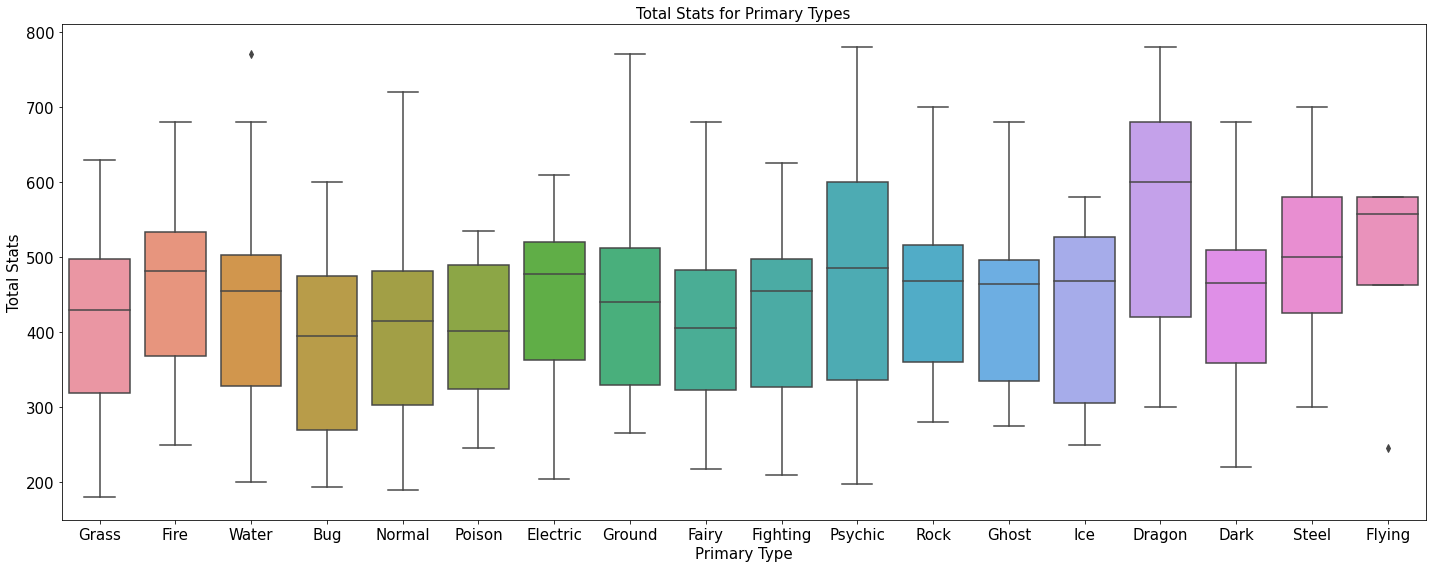

In [17]:
plt.figure(figsize=(20,8))

type1_stats = sns.boxplot(data=df, x='Type1', y='Total')
type1_stats.axes.set_title('Total Stats for Primary Types', fontsize=15)
type1_stats.set_xlabel('Primary Type', fontsize=15)
type1_stats.set_ylabel('Total Stats', fontsize=15)
type1_stats.tick_params(labelsize=15)

plt.tight_layout()

plt.show()

### Generations

#### Have Pokemons become more powerful with newer Generations?

Note that in Generation 6, "Mega Evolutions" were introduced, but are recorded as earlier Generations in the `pokemon` dataset here. 

Mega Evolved Pokemons have +100 `Total` stat points and could overestimate earlier Generations' Pokemon stats.

In [18]:
pd.read_sql_query("""SELECT Generation,
                         ROUND(
                             AVG(total), 1
                         ) AvgTotalStats
                     FROM pokemon
                     GROUP BY 1
                     ORDER BY 2 DESC""", engine)

,Generation,AvgTotalStats
0,4,459.0
1,6,436.4
2,3,436.2
3,5,435.0
4,1,426.8
5,2,418.3


Visualised:

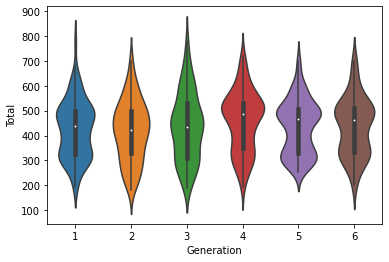

In [19]:
plt.clf()

sns.violinplot(x=df['Generation'], y=df['Total'])

plt.show()

Excluding Mega Evolution Pokemons:

In [20]:
pd.read_sql_query("""SELECT Generation,
                         ROUND(
                             AVG(total), 1
                         ) AvgTotalStats
                     FROM pokemon
                     WHERE Name NOT LIKE '%Mega %'
                     GROUP BY 1
                     ORDER BY 2 DESC""", engine)

,Generation,AvgTotalStats
0,4,451.9
1,5,434.3
2,6,433.1
3,3,411.6
4,1,407.1
5,2,406.2


#### Top 3 Strongest Pokemons (by `Total` stats) of each generation

In [21]:
pd.read_sql_query("""SELECT *
                     FROM (
                         SELECT
                             Generation,
                             RANK() OVER (
                                 PARTITION BY Generation
                                 ORDER BY Total DESC
                             ) Rank,
                             Name,
                             CASE 
                                 WHEN Legendary = 1 THEN "Yes" ELSE "No" 
                             END Legendary,
                             Total,
                             HP,
                             Attack Atk,
                             Defense Def,
                             SpAtk,
                             SpDef,
                             Speed
                         FROM pokemon
                     )
                     WHERE Rank <= 3
                     ORDER BY Generation, Rank""", engine)

,Generation,Rank,Name,Legendary,Total,HP,Atk,Def,SpAtk,SpDef,Speed
0,1,1,MewtwoMega Mewtwo X,Yes,780,106,190,100,154,100,130
1,1,1,MewtwoMega Mewtwo Y,Yes,780,106,150,70,194,120,140
2,1,3,Mewtwo,Yes,680,106,110,90,154,90,130
3,2,1,TyranitarMega Tyranitar,No,700,100,164,150,95,120,71
4,2,2,Lugia,Yes,680,106,90,130,90,154,110
5,2,2,Ho-oh,Yes,680,106,130,90,110,154,90
6,3,1,RayquazaMega Rayquaza,Yes,780,105,180,100,180,100,115
7,3,2,KyogrePrimal Kyogre,Yes,770,100,150,90,180,160,90
8,3,2,GroudonPrimal Groudon,Yes,770,100,180,160,150,90,90
9,4,1,Arceus,Yes,720,120,120,120,120,120,120


Excluding Mega Evolutions:

In [22]:
pd.read_sql_query("""SELECT *
                     FROM (
                         SELECT
                             Generation,
                             RANK() OVER (
                                 PARTITION BY Generation
                                 ORDER BY Total DESC
                             ) Rank,
                             Name,
                             CASE 
                                 WHEN Legendary = 1 THEN "Yes" ELSE "No" 
                             END Legendary,
                             Total,
                             HP,
                             Attack Atk,
                             Defense Def,
                             SpAtk,
                             SpDef,
                             Speed
                         FROM pokemon
                         WHERE Name NOT LIKE '%Mega %'
                     )
                     WHERE Rank <= 3
                     ORDER BY Generation, Rank""", engine)

,Generation,Rank,Name,Legendary,Total,HP,Atk,Def,SpAtk,SpDef,Speed
0,1,1,Mewtwo,Yes,680,106,110,90,154,90,130
1,1,2,Dragonite,No,600,91,134,95,100,100,80
2,1,2,Mew,No,600,100,100,100,100,100,100
3,2,1,Lugia,Yes,680,106,90,130,90,154,110
4,2,1,Ho-oh,Yes,680,106,130,90,110,154,90
5,2,3,Tyranitar,No,600,100,134,110,95,100,61
6,2,3,Celebi,No,600,100,100,100,100,100,100
7,3,1,KyogrePrimal Kyogre,Yes,770,100,150,90,180,160,90
8,3,1,GroudonPrimal Groudon,Yes,770,100,180,160,150,90,90
9,3,3,Rayquaza,Yes,680,105,150,90,150,90,95


Excluding Legendary Pokemons and Mega Evolutions:

In [23]:
pd.read_sql_query("""SELECT *
                     FROM (
                         SELECT
                             Generation,
                             RANK() OVER (
                                 PARTITION BY Generation
                                 ORDER BY Total DESC
                             ) Rank,
                             Name,
                             Total,
                             HP,
                             Attack Atk,
                             Defense Def,
                             SpAtk,
                             SpDef,
                             Speed
                         FROM pokemon
                         WHERE Legendary = 0
                             AND Name NOT LIKE '%Mega %'
                     )
                     WHERE Rank <= 3
                     ORDER BY Generation, Rank""", engine)

,Generation,Rank,Name,Total,HP,Atk,Def,SpAtk,SpDef,Speed
0,1,1,Dragonite,600,91,134,95,100,100,80
1,1,1,Mew,600,100,100,100,100,100,100
2,1,3,Arcanine,555,90,110,80,100,80,95
3,2,1,Tyranitar,600,100,134,110,95,100,61
4,2,1,Celebi,600,100,100,100,100,100,100
5,2,3,Kingdra,540,75,95,95,95,95,85
6,2,3,Blissey,540,255,10,10,75,135,55
7,3,1,Slaking,670,150,160,100,95,65,100
8,3,2,Salamence,600,95,135,80,110,80,100
9,3,2,Metagross,600,80,135,130,95,90,70


#### Which generation had the strongest Legendary Pokemons?

Excluding Mega Evolutions:

In [24]:
pd.read_sql_query("""SELECT Generation,
                         ROUND(AVG(Total), 1) AvgTotalStats,
                         ROUND(AVG(HP), 1) AvgHP,
                         ROUND(AVG(Attack), 1) AvgAtk,
                         ROUND(AVG(Defense), 1) AvgDef,
                         ROUND(AVG(SpAtk), 1) AvgSpAtk,
                         ROUND(AVG(SpDef), 1) AvgSpDef,
                         ROUND(AVG(Speed), 1) AvgSpeed,
                         COUNT(*) Count
                     FROM pokemon
                     WHERE Legendary = 1
                         AND Name NOT LIKE '%Mega %'
                     GROUP BY 1
                     ORDER BY 2 DESC""", engine)

,Generation,AvgTotalStats,AvgHP,AvgAtk,AvgDef,AvgSpAtk,AvgSpDef,AvgSpeed,Count
0,4,634.6,100.8,109.8,103.5,116.2,103.5,100.7,13
1,6,634.3,92.9,120.3,100.1,127.6,113.0,80.4,7
2,3,633.3,80.3,114.7,107.3,119.3,112.0,99.7,15
3,2,620.0,103.4,99.0,99.0,99.0,119.6,100.0,5
4,5,618.7,96.1,120.3,90.7,117.8,92.1,101.7,15
5,1,605.0,94.0,96.3,91.3,124.8,97.5,101.3,4
